One can open this tutorial in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/RQC_School_Rapid_prototyping/2_Optimization_of_spin_echo.ipynb)

## Here we import all necessary libraries.

In [5]:
# the central library we are going to use
# to operate with tensors and to perform
# optimization
import tensorflow as tf

# library for plotting
import matplotlib.style as style
import matplotlib.pyplot as plt

import math

In this notebook we optimize control signal in order to atchieve better revival in the experiment with spin echo. We consider a system of non-interecting spins. Each spin has Hamiltonian $H = \epsilon \sigma_z$, where $\epsilon\sim N(0, \sigma)$. At the begining all spins in the initial state $|\uparrow\rangle$, then they are turned to $xy$ plane and start to spread due to disordered parameter $\epsilon$. After some time $T$ we apply control signal of the following form $A(t)\sigma_x$ to an ensemble, where $t\in [T, T+T_c]$. Then, we wait time $T$ and expect to have revival of $\langle\sigma\rangle_y$. Our gole is to optimize discretized $A(t)$ in order to get better revival. In the block of code below we have a class that contains all necessary methods to solve this task.

In [17]:
# Pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# All Pauli matrices in one tensor of shape (3, 2, 2)
sigma = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

class ensemble_of_spins:
    """Class describes and ensamble of non-interacting spins under
    external control.
        Args:
            rho: complex valued tensor of shape (2, 2), initial state
            H: complex valued tensor of shape (2, 2), Hamiltonian
            N: int dtype value, number of spins
            dt: float dtype value, time step
            T: float dtype value, waiting time befor end after
                control signal
            T_c: float dtype value, duration of a control signal
            std: float dtype value, the standard deviation of
                Hamiltonian ampl.
            max_ampl: float dtype value, maximum amplitude of
                a control signal"""
    def __init__(self,
                 rho,
                 H,
                 N=10000,
                 dt=0.1, 
                 T=10.,
                 T_c=5.,
                 std=1.,
                 max_ampl=1.):
        self.dtype = rho.dtype
        self.N = N
        self.rho = rho
        # here we multiply Hamiltonian of each spin by random, normally
        # distributed value in order to reflect disorder in a system
        delta = std * tf.random.normal((N, 1, 1))
        delta = tf.cast(delta, dtype=self.dtype)
        self.H = H * delta
        # evolution operator for t = T
        self.UT = tf.linalg.expm(-1j * T * self.H)
        # evolution operator for t = dt
        self.Udt = tf.linalg.expm(-1j * dt * self.H)
        self.T = T
        self.T_c = T_c
        # number of discrete time steps corresponding to time T
        self.steps = int(T / dt)
        # number of discrete time steps corresponding to time T_c
        self.control_steps = int(T_c / dt)
        # control signal we want to tune
        self.ampl = tf.Variable(tf.random.normal((self.control_steps,), 
                                                 dtype=tf.float64))
        self.max_ampl = max_ampl

    @tf.function # this decorator accelerates calculations
    def optimization_one_step(self, opt, fun, lmbd):
        """Performs one step of optimization.
        Args:
            opt: tf optimizer
            fun: function that takes the final state as an input
                and returns a value, that we want to minimize
        Returns:
            float dtype value, value of loss function"""

        with tf.GradientTape() as tape:
            # initial density matrices of each spin
            rho = tf.tile(self.rho[tf.newaxis], (self.N, 1, 1))

            # clipping of a control signal (-self.max_ampl, self.max_ampl)
            gated_ampl = self.max_ampl * tf.nn.tanh(self.ampl)
            complex_gated_ampl = tf.cast(gated_ampl, dtype=tf.complex128)
            control = tf.tensordot(complex_gated_ampl, sigma_x, axes=0)

            # Hamiltonians with a control signal
            H_c = self.H[:, tf.newaxis] + control

            # corresponding evolution operators
            U_c = tf.linalg.expm(-1j * H_c * dt)

            # evolution of density matrices before control signal
            rho = self.UT @ rho @ tf.linalg.adjoint(self.UT)

            '''Here we replace standard for loop with tf.while_loop in
            order to make application of @tf.function decorator more stable.
            tf.while_loop usage is more complicated then standard for loop,
            you may delete @tf.function and use standard for loop with slight
            loose of speed.'''
            # termination condition
            cond = lambda i, rho: i < self.control_steps
            # body of a loop, evolution of a system for small time step dt
            body = lambda i, rho: [i+1,
                                U_c[:, i] @ rho @ tf.linalg.adjoint(U_c[:, i])]
            # initial index
            i0 = tf.constant(0)
            # simulation loop
            _, rho = tf.while_loop(cond, body, loop_vars=[i0, rho])

            # evolution of density matrices after control signal
            rho = self.UT @ rho @ tf.linalg.adjoint(self.UT)

            # loss function
            loss = fun(tf.reduce_mean(rho, axis=0))

            # L1 regularizer, makes signal piecewise continuous
            L1 = lmbd * tf.abs(self.ampl[:-1] - self.ampl[1:])

            # loss function with L1 regularizer
            loss_with_L1 = tf.cast(loss, dtype=self.ampl.dtype) + L1

        # gradient of a loss function with L1 regularizer
        grad = tape.gradient(loss_with_L1, self.ampl)

        # optimization step
        opt.apply_gradients(zip([grad], [self.ampl]))
        return loss

    @tf.function # this decorator accelerates calculations
    def optimize(self, iters, opt, fun, lmbd=0.05):
        """Optimizes control signal.
        Args:
            iters: int dtype value, number of Adam iterations
            lr: float dtype value, optimization step size
            fun: function that takes the final state as an input
                and returns a value, that we want to minimize
        Returns:
            real tensor of shape (iters,), loss vs time step"""

        # placeholder for sequence of loss function values per time step
        losses = tf.constant([0], dtype=tf.float32)

        '''Here again we replace standard for loop with tf.while_loop in
        order to make application of @tf.function decorator more stable.
        tf.while_loop usage is more complicated then standard for loop,
        you may delete @tf.function and use standard for loop with slight
        loose of speed.'''
        # termination condition
        cond = lambda i, losses: i < iters
        # body of a loop, optimization step and adding new value of loss to
        # losses
        def body(i, losses):
            loss = tf.cast(self.optimization_one_step(opt, fun, lmbd),
                           dtype=tf.float32)
            loss = loss[tf.newaxis]
            return [i+1, tf.concat([losses, loss], axis=0)]
        # initial index
        i0 = tf.constant(0)
        # optimization loop
        _, losses = tf.while_loop(cond, body,
                                  loop_vars=[i0, losses],
                                  shape_invariants=[i0.get_shape(), tf.TensorShape((None,))])
        return losses[1:]

    # we do not use @tf.function decorator here since we speed is not
    # important here
    def simulate(self, n):
        """Simulates dynamics of and ensamble under control signal
        Args:
            n: int dtype value, number of density matrices example
            per time step that function returns
        Returns:
            list of two complex valued tensors. First tensor of shape
            (number_of_time_steps, 3) is averaged bloch vector of an ensemble
            per time step. Second tensor of shape (number_of_time_steps, n, 3)
            is several bloch vectors of separate spins per time step"""

        # initial density matrices of each spin
        rho = tf.tile(self.rho[tf.newaxis], (self.N, 1, 1))

        # clipping of a control signal (-self.max_ampl, self.max_ampl)
        gated_ampl = self.max_ampl * tf.nn.tanh(self.ampl)
        complex_gated_ampl = tf.cast(gated_ampl, dtype=tf.complex128)
        control = tf.tensordot(complex_gated_ampl, sigma_x, axes=0)
        
        # Hamiltonians with a control signal
        H_c = self.H[:, tf.newaxis] + control

        # corresponding evolution operators
        U_c = tf.linalg.expm(-1j * H_c * dt)

        # this list will be filled by average rho vs time step
        av_rhos = []
        # this list will be filled by density matrices of several
        # separate spins vs time step
        rhos = []

        # filling lists
        av_rhos.append(tf.reduce_mean(rho, axis=0))
        rhos.append(rho[:n])

        # dynamics simulation before control signal
        for _ in range(self.steps):
            # dynamics
            rho = self.Udt @ rho @ tf.linalg.adjoint(self.Udt)
            # filling lists
            av_rhos.append(tf.reduce_mean(rho, axis=0))
            rhos.append(rho[:n])
        
        # dynamics simulation under control signal
        for i in range(self.control_steps):
            # dynamics
            rho = U_c[:, i] @ rho @ tf.linalg.adjoint(U_c[:, i])
            # filling lists
            av_rhos.append(tf.reduce_mean(rho, axis=0))
            rhos.append(rho[:n])

        # dynamics simulation after control signal
        for _ in range(2 * self.steps):
            # dynamics
            rho = self.Udt @ rho @ tf.linalg.adjoint(self.Udt)
            # filling lists
            av_rhos.append(tf.reduce_mean(rho, axis=0))
            rhos.append(rho[:n])

        av_rhos = tf.convert_to_tensor(av_rhos)
        rhos = tf.convert_to_tensor(rhos)
        # corresponding bloch vectors
        av_X = tf.einsum('qij,pji->qp', av_rhos, sigma)
        X = tf.einsum('qkij,pji->qkp', rhos, sigma)

        return av_X, X

    def control_signal(self):
        """Returns control signal, real tesnor os shape (number_of steps,)"""
        return self.max_ampl * tf.nn.tanh(self.ampl)

    def set_pi_impuls(self):
        """Sets standard pi pulse as a control signal"""
        T_c = 0.5 * math.pi / self.max_ampl
        c_duration = int(T_c / dt + 1e-3)
        total_duration = self.ampl.shape[0]
        i = int((total_duration - c_duration) / 2)
        self.ampl[:i].assign(0 * tf.ones((i,), dtype=self.ampl.dtype))
        self.ampl[i:i+c_duration].assign(1e8 * tf.ones((c_duration,),
                                                       dtype=self.ampl.dtype))
        self.ampl[i+c_duration:].assign(0 * tf.ones((self.ampl[i+c_duration:].shape[0],),
                                                       dtype=self.ampl.dtype))

Optimization of control sequance and simulation of ensemble dynamics

In [18]:
#=====================Parameters====================#
lr = 0.1  # optimization step size
iters = 500  # number of optimization steps
N=10000  # number of spins in an ensemble
dt=0.1  # time step
T=10.  # time before and fter control signal
T_c=6.  # duration of a control signal
max_ampl=1.  # maximum amplitude of a control signal
#===================================================#

# unperturbed Hamiltonian
H = tf.constant([[0.5, 0], [0, -0.5]], dtype=tf.complex128)
# initial density matrix
rho = 0.5 * (tf.eye(2, dtype=tf.complex128) + sigma_y)
# function we want to minimize (<\sigma_y> at last time step)
fun = lambda rho: tf.linalg.trace(rho @ sigma_y)
# optimizer
opt = tf.optimizers.Adam(lr)

# two ensembles of spins.
# for the first ensemble we optimize its control signal
# for the second ensemble we simply use standart pi pulse
e_tuned = ensemble_of_spins(rho, H, N=N, dt=dt, T=T,
                            T_c=T_c, max_ampl=max_ampl)
e_standard = ensemble_of_spins(rho, H, N=N, dt=dt, T=T,
                               T_c=T_c, max_ampl=max_ampl)

# setting pi pulse
e_standard.set_pi_impuls()

# optimizing control signal
losses = e_tuned.optimize(iters, opt, fun)

# ensembles dynamics simulation
av_X_tuned, X_tuned = e_tuned.simulate(10)
av_X_standard, X_standard = e_standard.simulate(10)

Plotting value of loss function ($\langle\sigma^{y} \rangle$ at last time step) per iteration

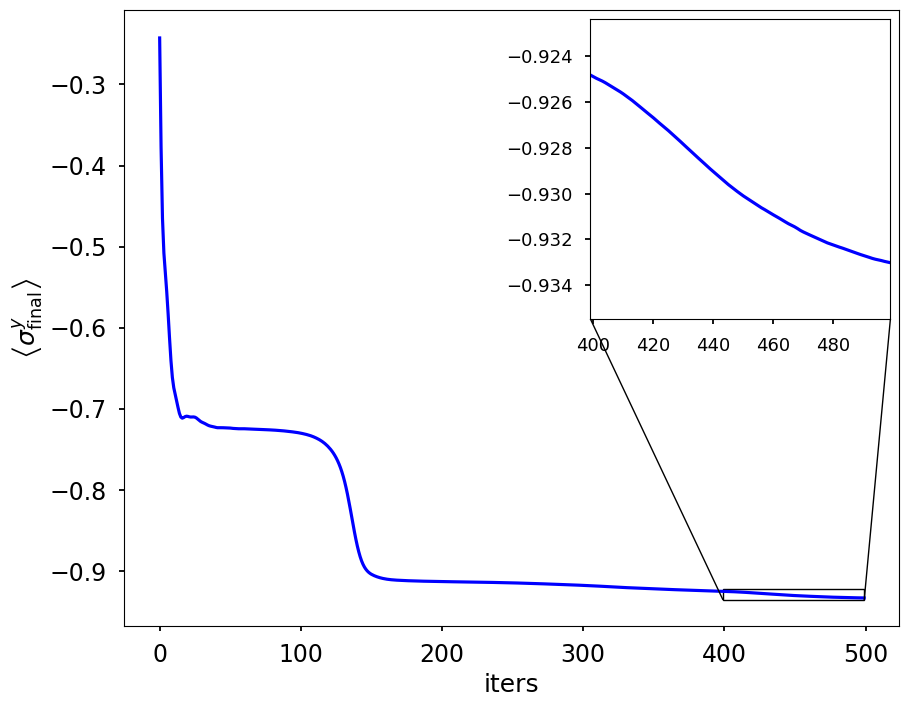

In [214]:
style.use('seaborn-talk')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(losses, 'b')
ax.set_xlabel('iters', fontsize=18)
ax.set_ylabel(r'$\left\langle\sigma^y_{\rm final}\right\rangle$', fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=17)

axins = inset_axes(ax, 3, 3, loc=1)
axins.set_xlim(iters-101, iters-1)
inset_size = losses[-101] - losses[-1]
axins.set_ylim(losses[-1] - 0.3 * inset_size, losses[-101] + 0.3 * inset_size)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0", linewidth=1)
axins.plot(losses, 'b')
axins.spines['bottom'].set_color('black')
axins.spines['top'].set_color('black')
axins.spines['left'].set_color('black')
axins.spines['right'].set_color('black')
axins.tick_params(axis='both', which='both', labelsize=13)
plt.savefig('loss_vs_iter.pdf')

Plotting dynamics of averaged density matrix (in terms of bloch vector)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


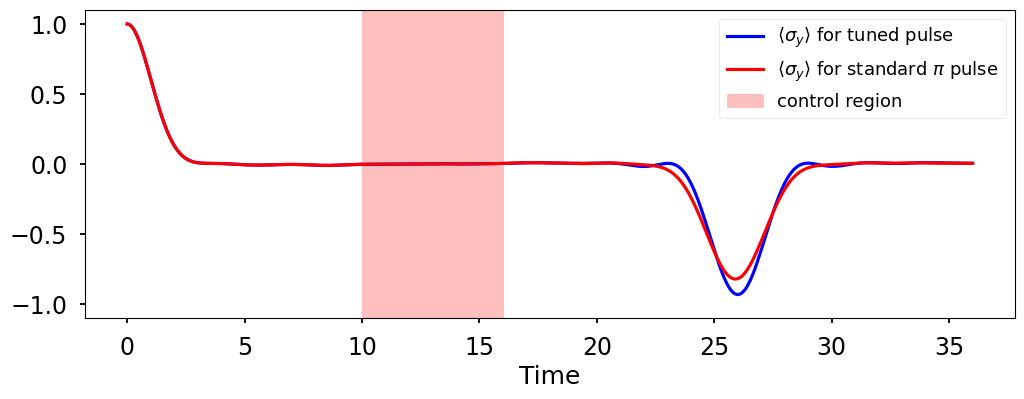

In [212]:
plt.figure(figsize=(12, 4))
plt.tick_params(axis='both', which='both', labelsize=17)
plt.ylim(top=1.1, bottom=-1.1)
plt.plot(tf.linspace(0., 3*T+T_c, av_X_tuned.shape[0]),
         av_X_tuned[:, 1], 'b')
plt.plot(tf.linspace(0., 3*T+T_c, av_X_standard.shape[0]),
         av_X_standard[:, 1], 'r')
plt.axvspan(T, T + T_c, alpha=0.25, color='red')
plt.xlabel('Time', fontsize=18)
plt.legend([r'$\langle\sigma_y\rangle$ for tuned pulse',
            r'$\langle\sigma_y\rangle$ for standard $\pi$ pulse',
            r'control region'], fontsize=13)
plt.savefig('spin_echo_comparison.pdf')

Plotting optimized control signal and standard $\pi$ pulse.

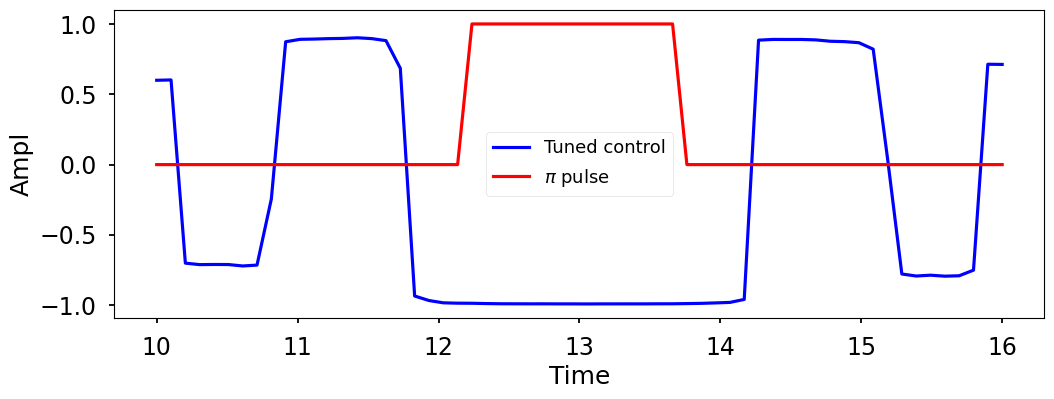

In [213]:
tuned_control = e_tuned.control_signal()
pi_pulse = e_standard.control_signal()
plt.figure(figsize=(12, 4))
plt.tick_params(axis='both', which='both', labelsize=17)
plt.plot(tf.linspace(T, T+T_c, pi_pulse.shape[0]), tuned_control, 'blue')
plt.plot(tf.linspace(T, T+T_c, pi_pulse.shape[0]), pi_pulse, 'red')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Ampl', fontsize=18)
plt.legend(['Tuned control', r'$\pi$ pulse'], fontsize=13)
plt.savefig('control_signals.pdf')